## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [79]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [80]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

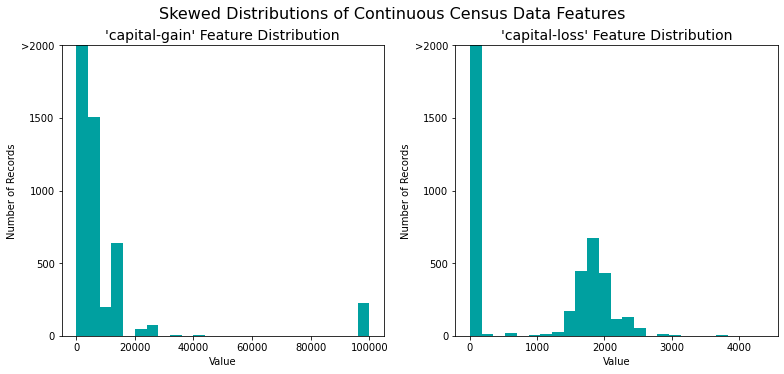

In [81]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

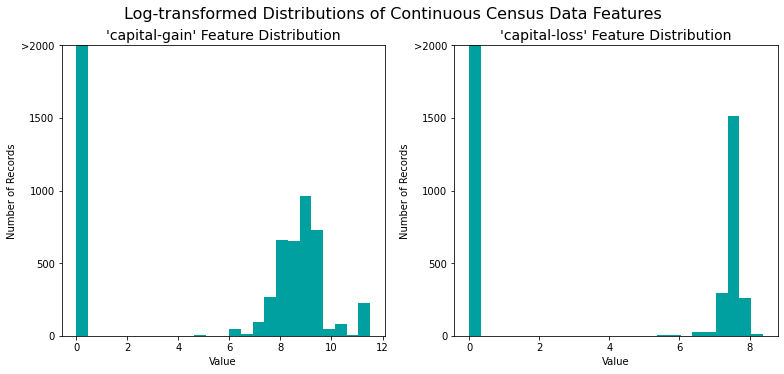

In [82]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [83]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [84]:
log_data = features_log_minmax_transform

### Inspection of features based upon first round of feature importance
1. Non object values seem to contribute alot (top 5) if we one-hot encode everything

### Inspection of features - 2nd round (removed all categorical columns)


In [85]:
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  float64
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
dtypes: float64(5), object(8)
memory usage: 4.5+ MB


#### Inspecting unique values of **Categorical** columns

In [86]:
for c in log_data.select_dtypes(include=['object']).columns:
  print(c)
  print(len(log_data[c].unique()))
  print()

workclass
7

education_level
16

marital-status
7

occupation
14

relationship
6

race
5

sex
2

native-country
41



### Relationship between education level and income

In [96]:
import matplotlib.pyplot as plt

# TODO: Encode the 'income_raw' data to numerical values
income = data['income'].map({'>50K': 1, '<=50K':0})

In [100]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
# Only converts categorical variables - https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

log_data = features_log_minmax_transform

# 1st round - one hot encode everything
features_final = pd.get_dummies(log_data)

# 2nd round - drop all categorical columns
# features_final = log_data.select_dtypes(exclude=['object'])

# 3rd round - one hot encode a low unique count categorical columns, i.e. sex and race
# features_final = log_data.select_dtypes(exclude=['object']).join(pd.get_dummies(log_data[['sex', 'race']]))

# 4th round - one hot encode a mid unique count columns, i.e. relationship maritial status, workclass
# features_final = log_data.select_dtypes(exclude=['object']).join(pd.get_dummies(log_data[['sex', 'race', 'workclass']]))

# 5th round - basically only included columns with values after inspecting feature_importance
features_final = pd.get_dummies(log_data)[['age',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ Federal-gov',
 'workclass_ Self-emp-not-inc',
 'education_level_ Bachelors',
 'education_level_ HS-grad',
 'education_level_ Masters',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'occupation_ Exec-managerial',
 'occupation_ Farming-fishing',
 'occupation_ Handlers-cleaners',
 'occupation_ Machine-op-inspct',
 'occupation_ Other-service',
 'occupation_ Prof-specialty',
 'occupation_ Protective-serv',
 'occupation_ Sales',
 'occupation_ Tech-support',
 'relationship_ Not-in-family',
 'relationship_ Own-child',
 'relationship_ Wife',
 'race_ White',
 'sex_ Female',
 'native-country_ Mexico']]

# 6th round

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

27 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Self-emp-not-inc', 'education_level_ Bachelors', 'education_level_ HS-grad', 'education_level_ Masters', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'relationship_ Not-in-family', 'relationship_ Own-child', 'relationship_ Wife', 'race_ White', 'sex_ Female', 'native-country_ Mexico']


### Identifying NA rows

In [101]:
features_final[features_final.isnull().sum(axis=1) >= 1]
features_final.fillna(0)

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Self-emp-not-inc,education_level_ Bachelors,education_level_ HS-grad,education_level_ Masters,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,relationship_ Not-in-family,relationship_ Own-child,relationship_ Wife,race_ White,sex_ Female,native-country_ Mexico
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,0.219178,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
45218,0.301370,0.800000,0.000000,0.0,0.357143,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
45219,0.287671,0.800000,0.000000,0.0,0.500000,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
45220,0.369863,0.800000,0.747375,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [102]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


### Data Information

In [103]:
X_test.describe(include='float64')

,age,education-num,capital-gain,capital-loss,hours-per-week
count,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000
mean,0.292895,0.608351,0.062686,0.042264,0.407315
std,0.181563,0.170710,0.211224,0.190212,0.125780
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,0.982762,1.000000


In [104]:
# 1 column showing NaN
X_test[np.isnan(X_test['capital-gain'])]

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Self-emp-not-inc,education_level_ Bachelors,education_level_ HS-grad,education_level_ Masters,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,relationship_ Not-in-family,relationship_ Own-child,relationship_ Wife,race_ White,sex_ Female,native-country_ Mexico


In [105]:
X_test = X_test.fillna(0)
X_test.describe(include='float64')

,age,education-num,capital-gain,capital-loss,hours-per-week
count,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000
mean,0.292895,0.608351,0.062686,0.042264,0.407315
std,0.181563,0.170710,0.211224,0.190212,0.125780
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,0.982762,1.000000


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

In [106]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, fbeta_score

model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, preds)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, preds, beta = 0.5)))

Final accuracy score on the testing data: 0.8422
Final F-score on the testing data: 0.6813


In [107]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, preds)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, preds, beta = 0.5)))

Final accuracy score on the testing data: 0.8576
Final F-score on the testing data: 0.7246


<BarContainer object of 27 artists>

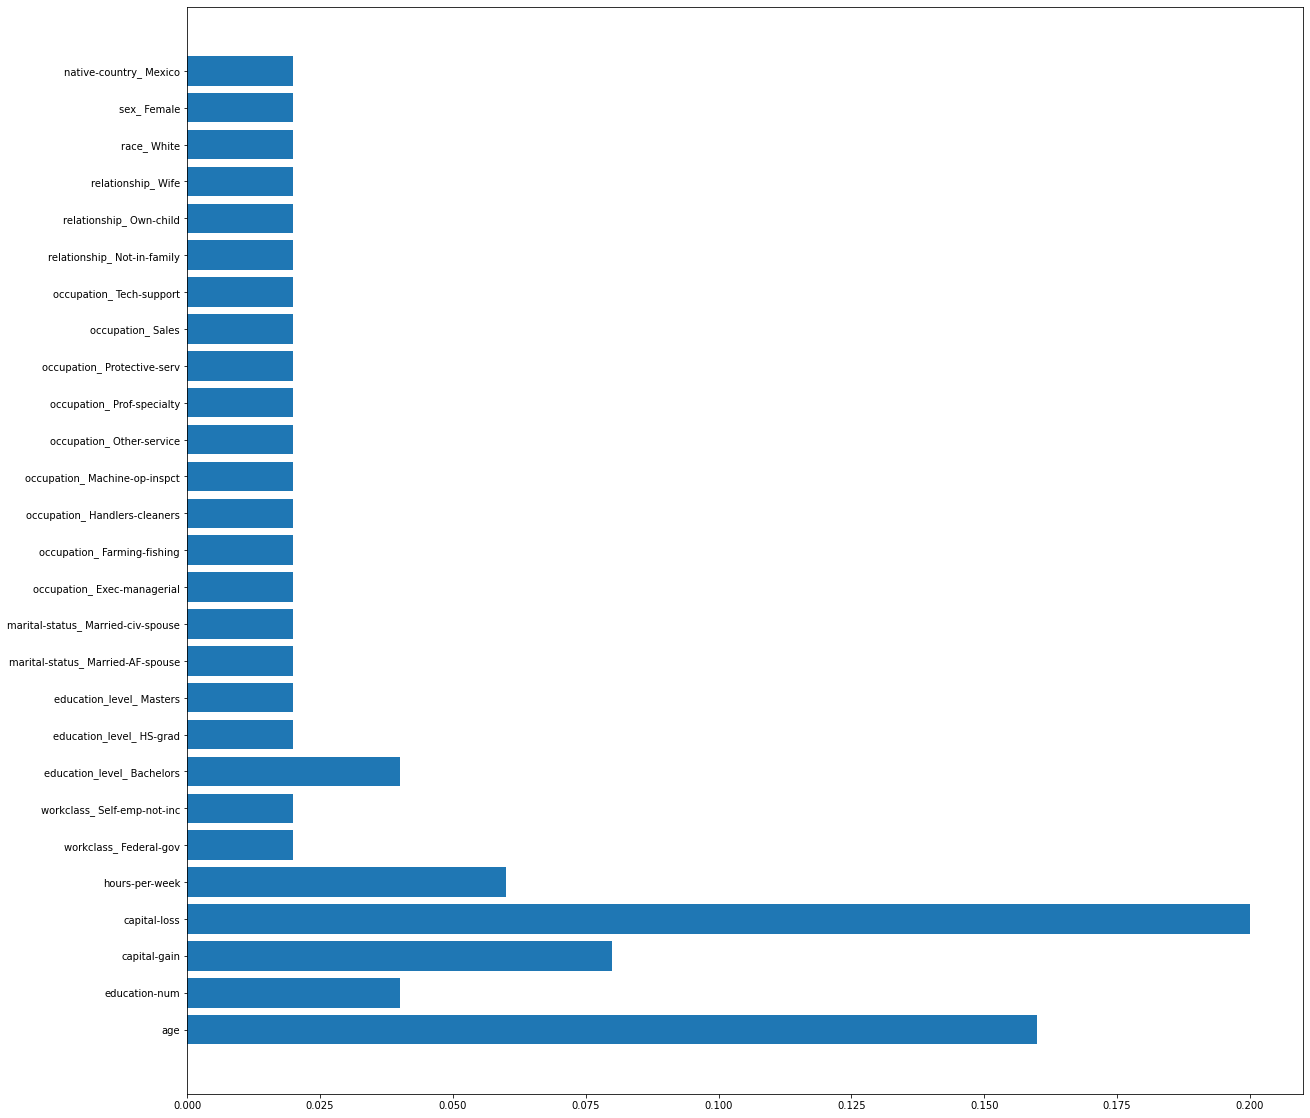

In [108]:
plt.figure(figsize=(20, 20))
plt.barh(X_train.columns, model.feature_importances_)

<BarContainer object of 27 artists>

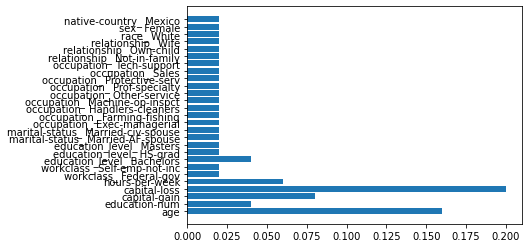

In [98]:
features_to_include = []
features_to_include_importance = []
for col, importance in zip(X_train.columns, model.feature_importances_):
    if importance > 0:
      features_to_include.append(col)
      features_to_include_importance.append(importance)

plt.barh(features_to_include, features_to_include_importance)

In [99]:
features_to_include

['age',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ Federal-gov',
 'workclass_ Self-emp-not-inc',
 'education_level_ Bachelors',
 'education_level_ HS-grad',
 'education_level_ Masters',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'occupation_ Exec-managerial',
 'occupation_ Farming-fishing',
 'occupation_ Handlers-cleaners',
 'occupation_ Machine-op-inspct',
 'occupation_ Other-service',
 'occupation_ Prof-specialty',
 'occupation_ Protective-serv',
 'occupation_ Sales',
 'occupation_ Tech-support',
 'relationship_ Not-in-family',
 'relationship_ Own-child',
 'relationship_ Wife',
 'race_ White',
 'sex_ Female',
 'native-country_ Mexico']